# Import Library

In [14]:
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt

# Plot Steps in Episode Comparison
在CartPole遊戲中step越多代表得到reward越多

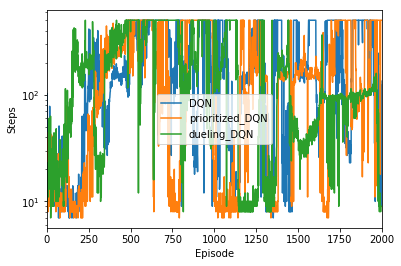

In [15]:
step_result = pd.concat([pd.read_csv('ref/DQN_CartPole.csv'),
                         pd.read_csv('ref/prioritized_DQN_CartPole.csv'),
                         pd.read_csv('ref/dueling_DQN_CartPole.csv')],
                        axis = 1)
step_result.plot()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.yscale("log")
plt.show()

# Plot CDF Steps in Episode Comparison
在CartPole遊戲中step越多代表得到reward越多

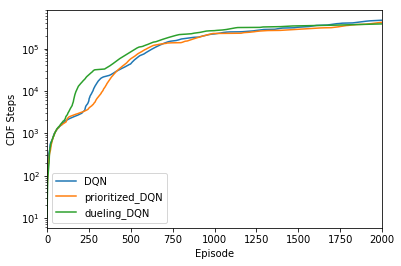

In [16]:
step_result.cumsum().plot()
plt.xlabel('Episode')
plt.ylabel('CDF Steps')
plt.yscale("log")
plt.show()

# Prioritized DQN Memory所需要的class

In [2]:
class SumTree(object):
    """
    This SumTree code is modified version and the original code is from: 
    https://github.com/jaara/AI-blog/blob/master/SumTree.py
    Story the data with it priority in tree and data frameworks.
    """
    data_pointer = 0

    def __init__(self, capacity):
        self.capacity = capacity  # for all priority values
        self.tree = np.zeros(2 * capacity - 1)
        # [--------------Parent nodes-------------][-------leaves to recode priority-------]
        #             size: capacity - 1                       size: capacity
        self.data = np.zeros(capacity, dtype=object)  # for all transitions
        # [--------------data frame-------------]
        #             size: capacity

    def add(self, p, data):
        tree_idx = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data  # update data_frame
        self.update(tree_idx, p)  # update tree_frame

        self.data_pointer += 1
        if self.data_pointer >= self.capacity:  # replace when exceed the capacity
            self.data_pointer = 0

    def update(self, tree_idx, p):
        change = p - self.tree[tree_idx]
        self.tree[tree_idx] = p
        # then propagate the change through tree
        while tree_idx != 0:    # this method is faster than the recursive loop in the reference code
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change

    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for transitions
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_idx = 0
        while True:     # the while loop is faster than the method in the reference code
            cl_idx = 2 * parent_idx + 1         # this leaf's left and right kids
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):        # reach bottom, end search
                leaf_idx = parent_idx
                break
            else:       # downward search, always search for a higher priority node
                if v <= self.tree[cl_idx]:
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    @property
    def total_p(self):
        return self.tree[0]  # the root


class Memory(object):  # stored as ( s, s_, r, a ) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    epsilon = 0.01  # small amount to avoid zero priority
    alpha = 0.6  # [0~1] convert the importance of TD error to priority
    beta = 0.4  # importance-sampling, from initial value increasing to 1
    beta_increment_per_sampling = 0.001
    abs_err_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def store(self, transition):
        max_p = np.max(self.tree.tree[-self.tree.capacity:])
        if max_p == 0:
            max_p = self.abs_err_upper
        self.tree.add(max_p, transition)   # set the max p for new p

    def sample(self, n):
        b_idx, b_memory, ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, self.tree.data[0].size)), np.empty((n, 1))
        pri_seg = self.tree.total_p / n       # priority segment
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])  # max = 1

        min_prob = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_p     # for later calculate ISweight
        for i in range(n):
            a, b = pri_seg * i, pri_seg * (i + 1)
            v = np.random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(v)
            prob = p / self.tree.total_p
            ISWeights[i, 0] = np.power(prob/min_prob, -self.beta)
            b_idx[i], b_memory[i, :] = idx, data
        return b_idx, b_memory, ISWeights

    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.epsilon  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.abs_err_upper)
        ps = np.power(clipped_errors, self.alpha)
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)


# 定義DeepQLearning
請大家將class中function的內容完成。投影片上應該也有答案～

In [3]:
class DeepQLearning:
    
    def __init__(
        self, 
        n_actions, 
        n_states, 
        dueling,
        prioritized,
        gamma = 0.9, #遠見程度
        epsilon = 0.9,  #保守程度，越大就越容易用Q值大小來採取行動；越小則越容易產生隨機行動
        epsilon_increase = None,
        learning_rate = 0.001, #神經網路的更新率
        memory_size = 50, #####
        batch_size = 32, #####
        nueron_num = 10,
        
    ):
        
        self.dueling = dueling
        self.prioritized = prioritized
        self.n_actions = n_actions
        self.n_states = n_states
        self.gamma = gamma
        self.epsilon_max = epsilon #####
        self.epsilon_increase = epsilon_increase #####
        self.epsilon = 0 if epsilon_increase is not None else epsilon #####
        self.lr = learning_rate
        self.memory_size = memory_size #####
        self.memory_counter = 0 #####
        self.batch_size = batch_size ####
        self.nueron_num = nueron_num
        ##### initialize memory
        if self.prioritized:
            self.memory = Memory(capacity=self.memory_size)
        else:
            self.memory = np.zeros((self.memory_size, n_states * 2 + 2))
        """
        memory用來記錄探索環境所蒐集到的資料用來更新神經網路，從公式Q_target = R(s,a) + max(Q(s_,a))*Gamma
        得知我們需要存取的資訊有s(current state), s_(next state), r(reward), a(action) 因此總共需要 2*n_states
        +2的dimension
        """
        
        tf.reset_default_graph() ## 重新 build graph 需要跑這行
        self.sess = tf.Session() #宣告session
        #輸入current state
        self.state_input = tf.placeholder(shape = [None, self.n_states], 
                                          name = 'input',
                                          dtype = tf.float32)
        #q_target = R(s, action) + Q(s_)*Gamma 
        self.q_target = tf.placeholder(shape = [None, self.n_actions], 
                                       name = 'q_target',
                                       dtype = tf.float32)
        if self.prioritized:
            self.ISWeights = tf.placeholder(shape=[None, 1], name='IS_weights', dtype=tf.float32)
        #搭建神經網路
        if self.dueling:
            with tf.variable_scope('Q_table'):
                self.q_eval = self.build_dueling_network(self.nueron_num, Trainable = True, scope = 'net_eval') 
                self.q_next = self.build_dueling_network(self.nueron_num, Trainable = False, scope = 'net_target') ##### 利用另外一個參數較舊的神經網路來給出下一步的q值並計算q_target
        else:
            with tf.variable_scope('Q_table'):
                self.q_eval = self.build_network(self.nueron_num, Trainable = True, scope = 'net_eval') 
                self.q_next = self.build_network(self.nueron_num, Trainable = False, scope = 'net_target') ##### 利用另外一個參數較舊的神經網路來給出下一步的q值並計算q_target

        #管理神經網路的parameters
        self.Qnet_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Q_table/net_eval')
        self.Qnet_target_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Q_table/net_target') #####
        #更新舊神經網路的參數
        self.replace_net_params = [tf.assign(old, new) for old, new in zip(self.Qnet_target_params, self.Qnet_eval_params)]
        
        #計算q_target和q_eval的mse來更新神經網路的參數
        if self.prioritized:
            self.abs_errors = tf.reduce_sum(tf.abs(self.q_target - self.q_eval), axis=1)    # for updating Sumtree
            self.loss = tf.reduce_mean(self.ISWeights * tf.squared_difference(self.q_target, self.q_eval))
        else:
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        
        self.train = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss, var_list=self.Qnet_eval_params)
        
        self.sess.run(tf.global_variables_initializer()) #將神經網路初始化
    
    def write_memory(self, current_state, next_state, reward, action): #####
        if self.prioritized:    # prioritized replay
            env_info = np.concatenate([current_state, next_state, [reward], [action]]) 
            self.memory.store(env_info)
        else:
            env_info = np.concatenate([current_state, next_state, [reward], [action]]) 
            save_index = self.memory_counter%self.memory_size
            self.memory[save_index, :] = env_info
            self.memory_counter+=1
            if self.memory_counter%self.memory_size == 0:
                self.memory_counter = self.memory_size

    
    def build_network(self, neuron_num, Trainable, scope): 
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            
            x_h1 = tf.layers.dense(inputs = self.state_input, units = neuron_num, activation = tf.nn.tanh, kernel_initializer=init_w, bias_initializer=init_b, trainable=Trainable) 
            
            x_h2 = tf.layers.dense(inputs = x_h1, units = neuron_num, activation = tf.nn.tanh, kernel_initializer=init_w, bias_initializer=init_b, trainable=Trainable)  
            
            output = tf.layers.dense(inputs = x_h2, units = self.n_actions, kernel_initializer=init_w, bias_initializer=init_b, trainable=Trainable)
        
        return output #輸出‘不同動作’對應的Q值 
    
    def build_dueling_network(self, neuron_num, Trainable, scope):      
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            h1 = tf.layers.dense(inputs = self.state_input, 
                                       units = neuron_num, 
                                       activation = tf.nn.tanh, 
                                       kernel_initializer=init_w, 
                                       bias_initializer=init_b, 
                                       trainable=Trainable) 
            #build state value network
            with tf.variable_scope('state_value'):
                

                v_h2 = tf.layers.dense(inputs = h1, 
                                       units = neuron_num, 
                                       activation = tf.nn.tanh, 
                                       kernel_initializer=init_w, 
                                       bias_initializer=init_b, 
                                       trainable=Trainable)  

                state_value = tf.layers.dense(inputs = v_h2, 
                                              units = 1, 
                                              kernel_initializer=init_w, 
                                              bias_initializer=init_b, 
                                              trainable=Trainable)
            
            #build advantage network
            with tf.variable_scope('advantage'):
                a_h2 = tf.layers.dense(inputs = h1, 
                                       units = neuron_num, 
                                       activation = tf.nn.tanh, 
                                       kernel_initializer=init_w, 
                                       bias_initializer=init_b, 
                                       trainable=Trainable)  

                advantage = tf.layers.dense(inputs = a_h2, 
                                            units = self.n_actions, 
                                            kernel_initializer=init_w, 
                                            bias_initializer=init_b, 
                                            trainable=Trainable)
            #將state value和advantage相加
            output = state_value + (advantage - tf.reduce_mean(advantage, axis=1, keep_dims=True))
            
        return output #輸出‘不同動作’對應的Q值 
            
    def choose_action(self, current_state):
        if np.random.uniform() < self.epsilon: 
            #選擇產生估計Q值較大的行動
            q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input: current_state[np.newaxis, :]})
            self.action = np.argmax(q_eval)
        else:
            #採取隨機行動
            self.action = np.random.randint(0, self.n_actions)
          
   
        return self.action
    
    def learn(self, current_state, reward, next_state, update_params): #####
        
        if update_params: #####
            self.sess.run(self.replace_net_params)
            #print('update parameters')
        
        #####從記憶中抽取過去的經驗來做更新
        if self.prioritized:
            tree_idx, past_experience, ISWeights = self.memory.sample(self.batch_size)
        else:    
            if self.memory_counter > self.memory_size:
                sample_index = np.random.choice(self.memory_size, size=self.batch_size)
            else:
                sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
            past_experience = self.memory[sample_index, :]
        
        current_state = past_experience[:, 0:self.n_states]
        next_state = past_experience[:, self.n_states:self.n_states*2]
        reward = past_experience[:, self.n_states*2]
        action = past_experience[:, self.n_states*2+1].astype(int)
        index = np.arange(self.batch_size)

        #算出實際q值並用此更新神經網路參數
        q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input: current_state})
        q_next = self.sess.run(self.q_next, feed_dict={self.state_input: next_state})
        q_target = q_eval.copy()
        q_target[index, action] = reward + self.gamma*np.max(q_next, axis=1)
        if self.prioritized:
            _, abs_errors, self.cost = self.sess.run([self.train, self.abs_errors, self.loss],\
                                         feed_dict={self.state_input: current_state,\
                                                    self.q_target: q_target,\
                                                    self.ISWeights: ISWeights})
            self.memory.batch_update(tree_idx, abs_errors)   # update priority
        else:    
            _, self.cost = self.sess.run([self.train, self.loss], feed_dict={self.state_input: current_state,\
                                                                                self.q_target: q_target})        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increase if self.epsilon < self.epsilon_max else self.epsilon_max  
        
    def model_save(self, model_name):
        
        saver = tf.train.Saver()
        saver.save(self.sess, "saved_models/{}.ckpt".format(model_name))
    
    def model_restore(self, model_name):
        
        saver = tf.train.Saver()
        saver.restore(self.sess, "saved_models/{}.ckpt".format(model_name))
        

# Define Training的環境和步驟

In [4]:
def training(save_model, model_name):
    step_record = []
    reward_record = []
    learn_count = 0
    update_count = 0
    for episode in range(2000):
        # initial environment並給出起始的state
        current_state = env.reset()
        step = 0
        total_reward = 0
        while True:
            # 產生環境視窗
            env.render()

            # 根據現在的狀態選擇動作
            action = RL.choose_action(current_state)

            # 產生動作和環境互動後產生下一個狀態、獎勵值及遊戲是否結束
            next_state, reward, done, _ = env.step(action)
            
            # 調整reward
            if done:
                reward = -10
            else:
                reward = 0
            #怕玩太久，強迫結束
            if step ==500:
                done = True
            
            total_reward+=reward
            # 將資訊存至記憶體中以便進行experience replay
            RL.write_memory(current_state, next_state, reward, action)

            # 進行學習
            if learn_count <= 1000:
                learn_count+=1
            else:
                #進行參數更新
                if update_count==300:
                    update = True
                    update_count =0
                else:
                    update = False
                    update_count+=1
                
                RL.learn(current_state, reward, next_state, update)
            
            # break while loop when end of this episode
            if done:
                mean_reward = total_reward/step
                print('episode:{} steps:{} total reward:{} epsilon:{}'.format(episode, step, \
                       total_reward, RL.epsilon))
                step_record.append(step)
                reward_record.append(total_reward)
                break
            current_state = next_state
            step += 1

    # end of game
    if save_model:
        RL.model_save(model_name)
    print('game over')
    env.close()
    return step_record, reward_record

In [5]:
step_result = []
reward_result = []
env = gym.make('CartPole-v0')
env = env.unwrapped
env.seed(1)

RL = DeepQLearning( n_actions = 2, 
                    n_states = 4,
                    gamma = 0.99,
                    epsilon = 0.95,
                    epsilon_increase = 0.001,
                    learning_rate = 0.001,
                    memory_size = 10000,
                    batch_size = 32,
                    nueron_num = 10,
                    dueling = True,
                    prioritized = False
                    )
step_record, reward_record = training(save_model = True, model_name='cartpole_Prioritized_dqn')
step_result.append(pd.DataFrame(step_record))
reward_result.append(pd.DataFrame(reward_record))

episode:0 steps:44 total reward:-10 epsilon:0
episode:1 steps:15 total reward:-10 epsilon:0
episode:2 steps:11 total reward:-10 epsilon:0
episode:3 steps:14 total reward:-10 epsilon:0
episode:4 steps:35 total reward:-10 epsilon:0
episode:5 steps:15 total reward:-10 epsilon:0
episode:6 steps:23 total reward:-10 epsilon:0
episode:7 steps:8 total reward:-10 epsilon:0
episode:8 steps:38 total reward:-10 epsilon:0
episode:9 steps:16 total reward:-10 epsilon:0
episode:10 steps:11 total reward:-10 epsilon:0
episode:11 steps:10 total reward:-10 epsilon:0
episode:12 steps:19 total reward:-10 epsilon:0
episode:13 steps:30 total reward:-10 epsilon:0
episode:14 steps:23 total reward:-10 epsilon:0
episode:15 steps:22 total reward:-10 epsilon:0
episode:16 steps:9 total reward:-10 epsilon:0
episode:17 steps:11 total reward:-10 epsilon:0
episode:18 steps:12 total reward:-10 epsilon:0
episode:19 steps:10 total reward:-10 epsilon:0
episode:20 steps:15 total reward:-10 epsilon:0
episode:21 steps:29 total

episode:148 steps:8 total reward:-10 epsilon:0.95
episode:149 steps:10 total reward:-10 epsilon:0.95
episode:150 steps:9 total reward:-10 epsilon:0.95
episode:151 steps:8 total reward:-10 epsilon:0.95
episode:152 steps:9 total reward:-10 epsilon:0.95
episode:153 steps:8 total reward:-10 epsilon:0.95
episode:154 steps:9 total reward:-10 epsilon:0.95
episode:155 steps:8 total reward:-10 epsilon:0.95
episode:156 steps:9 total reward:-10 epsilon:0.95
episode:157 steps:10 total reward:-10 epsilon:0.95
episode:158 steps:9 total reward:-10 epsilon:0.95
episode:159 steps:8 total reward:-10 epsilon:0.95
episode:160 steps:9 total reward:-10 epsilon:0.95
episode:161 steps:7 total reward:-10 epsilon:0.95
episode:162 steps:9 total reward:-10 epsilon:0.95
episode:163 steps:8 total reward:-10 epsilon:0.95
episode:164 steps:8 total reward:-10 epsilon:0.95
episode:165 steps:9 total reward:-10 epsilon:0.95
episode:166 steps:9 total reward:-10 epsilon:0.95
episode:167 steps:10 total reward:-10 epsilon:0.

episode:310 steps:87 total reward:-10 epsilon:0.95
episode:311 steps:73 total reward:-10 epsilon:0.95
episode:312 steps:94 total reward:-10 epsilon:0.95
episode:313 steps:86 total reward:-10 epsilon:0.95
episode:314 steps:84 total reward:-10 epsilon:0.95
episode:315 steps:78 total reward:-10 epsilon:0.95
episode:316 steps:83 total reward:-10 epsilon:0.95
episode:317 steps:80 total reward:-10 epsilon:0.95
episode:318 steps:78 total reward:-10 epsilon:0.95
episode:319 steps:131 total reward:-10 epsilon:0.95
episode:320 steps:90 total reward:-10 epsilon:0.95
episode:321 steps:108 total reward:-10 epsilon:0.95
episode:322 steps:90 total reward:-10 epsilon:0.95
episode:323 steps:96 total reward:-10 epsilon:0.95
episode:324 steps:360 total reward:-10 epsilon:0.95
episode:325 steps:79 total reward:-10 epsilon:0.95
episode:326 steps:104 total reward:-10 epsilon:0.95
episode:327 steps:86 total reward:-10 epsilon:0.95
episode:328 steps:96 total reward:-10 epsilon:0.95
episode:329 steps:123 total

episode:468 steps:240 total reward:-10 epsilon:0.95
episode:469 steps:255 total reward:-10 epsilon:0.95
episode:470 steps:303 total reward:-10 epsilon:0.95
episode:471 steps:338 total reward:-10 epsilon:0.95
episode:472 steps:401 total reward:-10 epsilon:0.95
episode:473 steps:443 total reward:-10 epsilon:0.95
episode:474 steps:351 total reward:-10 epsilon:0.95
episode:475 steps:368 total reward:-10 epsilon:0.95
episode:476 steps:423 total reward:-10 epsilon:0.95
episode:477 steps:500 total reward:0 epsilon:0.95
episode:478 steps:383 total reward:-10 epsilon:0.95
episode:479 steps:500 total reward:0 epsilon:0.95
episode:480 steps:500 total reward:0 epsilon:0.95
episode:481 steps:500 total reward:0 epsilon:0.95
episode:482 steps:500 total reward:0 epsilon:0.95
episode:483 steps:500 total reward:0 epsilon:0.95
episode:484 steps:500 total reward:0 epsilon:0.95
episode:485 steps:500 total reward:0 epsilon:0.95
episode:486 steps:500 total reward:0 epsilon:0.95
episode:487 steps:500 total re

episode:630 steps:399 total reward:-10 epsilon:0.95
episode:631 steps:500 total reward:0 epsilon:0.95
episode:632 steps:500 total reward:0 epsilon:0.95
episode:633 steps:500 total reward:0 epsilon:0.95
episode:634 steps:500 total reward:0 epsilon:0.95
episode:635 steps:500 total reward:0 epsilon:0.95
episode:636 steps:405 total reward:-10 epsilon:0.95
episode:637 steps:11 total reward:-10 epsilon:0.95
episode:638 steps:172 total reward:-10 epsilon:0.95
episode:639 steps:8 total reward:-10 epsilon:0.95
episode:640 steps:159 total reward:-10 epsilon:0.95
episode:641 steps:27 total reward:-10 epsilon:0.95
episode:642 steps:179 total reward:-10 epsilon:0.95
episode:643 steps:84 total reward:-10 epsilon:0.95
episode:644 steps:203 total reward:-10 epsilon:0.95
episode:645 steps:219 total reward:-10 epsilon:0.95
episode:646 steps:226 total reward:-10 epsilon:0.95
episode:647 steps:193 total reward:-10 epsilon:0.95
episode:648 steps:232 total reward:-10 epsilon:0.95
episode:649 steps:238 total

episode:793 steps:24 total reward:-10 epsilon:0.95
episode:794 steps:10 total reward:-10 epsilon:0.95
episode:795 steps:12 total reward:-10 epsilon:0.95
episode:796 steps:18 total reward:-10 epsilon:0.95
episode:797 steps:26 total reward:-10 epsilon:0.95
episode:798 steps:89 total reward:-10 epsilon:0.95
episode:799 steps:500 total reward:0 epsilon:0.95
episode:800 steps:500 total reward:0 epsilon:0.95
episode:801 steps:171 total reward:-10 epsilon:0.95
episode:802 steps:203 total reward:-10 epsilon:0.95
episode:803 steps:187 total reward:-10 epsilon:0.95
episode:804 steps:203 total reward:-10 epsilon:0.95
episode:805 steps:264 total reward:-10 epsilon:0.95
episode:806 steps:500 total reward:0 epsilon:0.95
episode:807 steps:500 total reward:0 epsilon:0.95
episode:808 steps:500 total reward:0 epsilon:0.95
episode:809 steps:258 total reward:-10 epsilon:0.95
episode:810 steps:500 total reward:0 epsilon:0.95
episode:811 steps:500 total reward:0 epsilon:0.95
episode:812 steps:500 total rewa

episode:957 steps:500 total reward:0 epsilon:0.95
episode:958 steps:500 total reward:0 epsilon:0.95
episode:959 steps:500 total reward:0 epsilon:0.95
episode:960 steps:500 total reward:0 epsilon:0.95
episode:961 steps:500 total reward:0 epsilon:0.95
episode:962 steps:500 total reward:0 epsilon:0.95
episode:963 steps:500 total reward:0 epsilon:0.95
episode:964 steps:500 total reward:0 epsilon:0.95
episode:965 steps:500 total reward:0 epsilon:0.95
episode:966 steps:500 total reward:0 epsilon:0.95
episode:967 steps:500 total reward:0 epsilon:0.95
episode:968 steps:500 total reward:0 epsilon:0.95
episode:969 steps:500 total reward:0 epsilon:0.95
episode:970 steps:500 total reward:0 epsilon:0.95
episode:971 steps:500 total reward:0 epsilon:0.95
episode:972 steps:500 total reward:0 epsilon:0.95
episode:973 steps:500 total reward:0 epsilon:0.95
episode:974 steps:500 total reward:0 epsilon:0.95
episode:975 steps:500 total reward:0 epsilon:0.95
episode:976 steps:500 total reward:0 epsilon:0.95


episode:1122 steps:8 total reward:-10 epsilon:0.95
episode:1123 steps:8 total reward:-10 epsilon:0.95
episode:1124 steps:11 total reward:-10 epsilon:0.95
episode:1125 steps:8 total reward:-10 epsilon:0.95
episode:1126 steps:10 total reward:-10 epsilon:0.95
episode:1127 steps:9 total reward:-10 epsilon:0.95
episode:1128 steps:8 total reward:-10 epsilon:0.95
episode:1129 steps:9 total reward:-10 epsilon:0.95
episode:1130 steps:10 total reward:-10 epsilon:0.95
episode:1131 steps:9 total reward:-10 epsilon:0.95
episode:1132 steps:9 total reward:-10 epsilon:0.95
episode:1133 steps:11 total reward:-10 epsilon:0.95
episode:1134 steps:8 total reward:-10 epsilon:0.95
episode:1135 steps:10 total reward:-10 epsilon:0.95
episode:1136 steps:9 total reward:-10 epsilon:0.95
episode:1137 steps:9 total reward:-10 epsilon:0.95
episode:1138 steps:9 total reward:-10 epsilon:0.95
episode:1139 steps:10 total reward:-10 epsilon:0.95
episode:1140 steps:8 total reward:-10 epsilon:0.95
episode:1141 steps:7 tota

episode:1280 steps:228 total reward:-10 epsilon:0.95
episode:1281 steps:161 total reward:-10 epsilon:0.95
episode:1282 steps:165 total reward:-10 epsilon:0.95
episode:1283 steps:166 total reward:-10 epsilon:0.95
episode:1284 steps:188 total reward:-10 epsilon:0.95
episode:1285 steps:172 total reward:-10 epsilon:0.95
episode:1286 steps:131 total reward:-10 epsilon:0.95
episode:1287 steps:147 total reward:-10 epsilon:0.95
episode:1288 steps:166 total reward:-10 epsilon:0.95
episode:1289 steps:153 total reward:-10 epsilon:0.95
episode:1290 steps:134 total reward:-10 epsilon:0.95
episode:1291 steps:131 total reward:-10 epsilon:0.95
episode:1292 steps:135 total reward:-10 epsilon:0.95
episode:1293 steps:136 total reward:-10 epsilon:0.95
episode:1294 steps:132 total reward:-10 epsilon:0.95
episode:1295 steps:141 total reward:-10 epsilon:0.95
episode:1296 steps:155 total reward:-10 epsilon:0.95
episode:1297 steps:125 total reward:-10 epsilon:0.95
episode:1298 steps:136 total reward:-10 epsilo

episode:1437 steps:162 total reward:-10 epsilon:0.95
episode:1438 steps:154 total reward:-10 epsilon:0.95
episode:1439 steps:164 total reward:-10 epsilon:0.95
episode:1440 steps:160 total reward:-10 epsilon:0.95
episode:1441 steps:164 total reward:-10 epsilon:0.95
episode:1442 steps:162 total reward:-10 epsilon:0.95
episode:1443 steps:162 total reward:-10 epsilon:0.95
episode:1444 steps:167 total reward:-10 epsilon:0.95
episode:1445 steps:159 total reward:-10 epsilon:0.95
episode:1446 steps:175 total reward:-10 epsilon:0.95
episode:1447 steps:174 total reward:-10 epsilon:0.95
episode:1448 steps:179 total reward:-10 epsilon:0.95
episode:1449 steps:218 total reward:-10 epsilon:0.95
episode:1450 steps:342 total reward:-10 epsilon:0.95
episode:1451 steps:216 total reward:-10 epsilon:0.95
episode:1452 steps:178 total reward:-10 epsilon:0.95
episode:1453 steps:355 total reward:-10 epsilon:0.95
episode:1454 steps:500 total reward:0 epsilon:0.95
episode:1455 steps:36 total reward:-10 epsilon:0

episode:1592 steps:147 total reward:-10 epsilon:0.95
episode:1593 steps:146 total reward:-10 epsilon:0.95
episode:1594 steps:146 total reward:-10 epsilon:0.95
episode:1595 steps:145 total reward:-10 epsilon:0.95
episode:1596 steps:141 total reward:-10 epsilon:0.95
episode:1597 steps:148 total reward:-10 epsilon:0.95
episode:1598 steps:153 total reward:-10 epsilon:0.95
episode:1599 steps:150 total reward:-10 epsilon:0.95
episode:1600 steps:159 total reward:-10 epsilon:0.95
episode:1601 steps:172 total reward:-10 epsilon:0.95
episode:1602 steps:167 total reward:-10 epsilon:0.95
episode:1603 steps:182 total reward:-10 epsilon:0.95
episode:1604 steps:180 total reward:-10 epsilon:0.95
episode:1605 steps:171 total reward:-10 epsilon:0.95
episode:1606 steps:187 total reward:-10 epsilon:0.95
episode:1607 steps:230 total reward:-10 epsilon:0.95
episode:1608 steps:170 total reward:-10 epsilon:0.95
episode:1609 steps:153 total reward:-10 epsilon:0.95
episode:1610 steps:182 total reward:-10 epsilo

episode:1749 steps:500 total reward:0 epsilon:0.95
episode:1750 steps:500 total reward:0 epsilon:0.95
episode:1751 steps:500 total reward:0 epsilon:0.95
episode:1752 steps:500 total reward:0 epsilon:0.95
episode:1753 steps:500 total reward:0 epsilon:0.95
episode:1754 steps:500 total reward:0 epsilon:0.95
episode:1755 steps:500 total reward:0 epsilon:0.95
episode:1756 steps:500 total reward:0 epsilon:0.95
episode:1757 steps:500 total reward:0 epsilon:0.95
episode:1758 steps:500 total reward:0 epsilon:0.95
episode:1759 steps:500 total reward:0 epsilon:0.95
episode:1760 steps:500 total reward:0 epsilon:0.95
episode:1761 steps:500 total reward:0 epsilon:0.95
episode:1762 steps:500 total reward:0 epsilon:0.95
episode:1763 steps:500 total reward:0 epsilon:0.95
episode:1764 steps:500 total reward:0 epsilon:0.95
episode:1765 steps:500 total reward:0 epsilon:0.95
episode:1766 steps:500 total reward:0 epsilon:0.95
episode:1767 steps:500 total reward:0 epsilon:0.95
episode:1768 steps:500 total re

episode:1908 steps:500 total reward:0 epsilon:0.95
episode:1909 steps:500 total reward:0 epsilon:0.95
episode:1910 steps:500 total reward:0 epsilon:0.95
episode:1911 steps:500 total reward:0 epsilon:0.95
episode:1912 steps:500 total reward:0 epsilon:0.95
episode:1913 steps:500 total reward:0 epsilon:0.95
episode:1914 steps:500 total reward:0 epsilon:0.95
episode:1915 steps:500 total reward:0 epsilon:0.95
episode:1916 steps:500 total reward:0 epsilon:0.95
episode:1917 steps:500 total reward:0 epsilon:0.95
episode:1918 steps:124 total reward:-10 epsilon:0.95
episode:1919 steps:23 total reward:-10 epsilon:0.95
episode:1920 steps:122 total reward:-10 epsilon:0.95
episode:1921 steps:123 total reward:-10 epsilon:0.95
episode:1922 steps:135 total reward:-10 epsilon:0.95
episode:1923 steps:116 total reward:-10 epsilon:0.95
episode:1924 steps:168 total reward:-10 epsilon:0.95
episode:1925 steps:215 total reward:-10 epsilon:0.95
episode:1926 steps:210 total reward:-10 epsilon:0.95
episode:1927 s

In [7]:
step_result = pd.concat(step_result)
step_result.columns = ['prioritized_DQN']

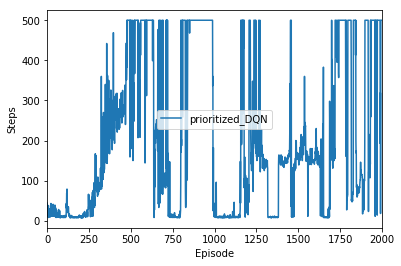

In [8]:
step_result.plot()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.show()